In [1]:
import pandas as pd
import numpy as np
import pydicom
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from PIL import Image 
from os import listdir

elementdict = {'STUDYDATE' : 3, 
               'STUDYTIME' : 4, 
               'AGE' : 14, 
               'SEX' : 13, 
               'VIEWPOSITION' : 16}

# For First Checkpoint

In [2]:
folder = './data/'
trainfolder = folder + 'stage_2_train_images/'
testfolder = folder + 'stage_2_test_images/'
file1 = folder + 'stage_2_train_labels.csv'
file2 = folder + 'stage_2_detailed_class_info.csv'

In [3]:
dflabel = pd.read_csv(file1)
dflabel.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [4]:
dfinfo = pd.read_csv(file2)
dfinfo.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [5]:
dcmfiles = [f for f in listdir(testfolder)]
dftestdata = pd.DataFrame(dcmfiles, columns=['filename'])
dftestdata.filename = dftestdata.filename.apply(lambda x: x.replace('.dcm', ''))
dftestdata.head()

,filename
0,0000a175-0e68-4ca4-b1af-167204a7e0bc
1,0005d3cc-3c3f-40b9-93c3-46231c3eb813
2,000686d7-f4fc-448d-97a0-44fa9c5d3aa6
3,000e3a7d-c0ca-4349-bb26-5af2d8993c3d
4,00100a24-854d-423d-a092-edcf6179e061


In [6]:
print(dfinfo['class'].unique())
print(len(dflabel), len(dfinfo), len(dflabel.patientId.unique()), len(dfinfo.patientId.unique()))

['No Lung Opacity / Not Normal' 'Normal' 'Lung Opacity']
30227 30227 26684 26684


In [7]:
df = dflabel.merge(dfinfo, how='inner', on='patientId')
del(dfinfo)
del(dflabel)
df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [8]:
def ExtractInfo(dcmdata, identifiers):
    lstdata = list(dcmdata.elements())
    retval = []
    for idx in identifiers:
        try:
            tempval = lstdata[identifiers[idx]].value
            retval.append(tempval)
        except:
            print('Unable to extract', idx)

    return retval

def ReadInfo(path, lstpatients):
    lstvals = []
    lstpixels = []
    for item in range(len(lstpatients)):
        pid = lstpatients[item]

        if item % 5000 == 0: 
            print('Processings patient {0} - {1}'.format(item, pid))
    
        file = folder + path + pid + '.dcm'
        datadcm = pydicom.read_file(file)
        lstvals.append(ExtractInfo(datadcm, elementdict))
        lstpixels.append(datadcm.pixel_array.flatten())
    
    dfelements = pd.DataFrame(lstvals)
    dfelements['PIXELS'] = lstpixels
    dfelements.columns = ['STUDYDATE', 'STUDYTIME', 'AGE', 'SEX', 'VIEWPOSITION', 'PIXELS']
    return dfelements

dfelements = ReadInfo('stage_2_train_images/', list(df.patientId))

Processings patient 0 - 0004cfab-14fd-4e49-80ba-63a80b6bddd6
Processings patient 5000 - 390eb7b5-2719-408a-b9ac-7ad6225c4889
Processings patient 10000 - 587b1026-7986-420e-aea4-ec1cef23af11
Processings patient 15000 - 7b8e6b7c-06c0-4006-8cbe-f1d92edeed07
Processings patient 20000 - 9c3edffc-7981-40c3-84b9-d719e49ce1db
Processings patient 25000 - b77ab795-de76-4715-b371-eb7be54b584c
Processings patient 30000 - d5d6f7e3-5143-4955-901e-cad92024fee0
Processings patient 35000 - f9c4f02b-52b5-4f36-96d7-b706d678d9b9


In [9]:
df[['studydate', 'studytime', 'age', 'sex', 'viewposition', 'pixels']] = dfelements.copy()
df['imagesize'] = df.pixels.apply(lambda x: x.shape)
df = df[['patientId', 'x', 'y', 'width', 'height', 
         'age', 'sex', 'viewposition', 'Target', 'class', 'pixels']]
df.age = df.age.apply(lambda x: np.int32(x))
#df.sex = df.sex.apply(lambda x: x.trim())
del(dfelements)
df.head()

,patientId,x,y,width,height,age,sex,viewposition,Target,class,pixels
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,51,b'F ',b'PA',0,No Lung Opacity / Not Normal,"[144, 128, 114, 105, 94, 82, 72, 66, 59, 54, 4..."
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,48,b'F ',b'PA',0,No Lung Opacity / Not Normal,"[31, 24, 19, 14, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,19,b'M ',b'AP',0,No Lung Opacity / Not Normal,"[4, 12, 11, 10, 10, 8, 9, 7, 10, 10, 10, 9, 9,..."
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,28,b'M ',b'PA',0,Normal,"[209, 211, 212, 212, 210, 207, 205, 204, 204, ..."
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,32,b'F ',b'AP',1,Lung Opacity,"[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, ..."


# For Third Checkpoint

I am planning to use the ML Pipeline to segregate the data. 

With ML1 corresponding to identifing a good quality image, i am now proceed to ML2 to identify a good lung to opaque lung. 

In both cases, I plan to use regular neural network to classify the images. The reason why I chose regular neural network is that the classification of identifiable objects (not normal or opacity) are based on the color segmentation and doesn't have a specific shape or size. Hence, I wanted to check the performance of the ML pipeline using regular neural network in this second checkpoint.

## Why is the ML pipeline important? 
Yes, training dataset has all the labels correctly defined for appropriate classes. However the test dataset don't. We need to be able to identify all three classes in the test dataset. The first step is to find if the image quality is acceptable if not, we need to advice the patient to redo the chest radiography. If the quality is acceptable, then we can go figure out the images are for a normal chest or for a chest with opacity. 

#### Internals of Model 2
The imagesize in all cases are 1024 X 1024 and hence the trainable parameters are huge. The following steps are the outlined steps for this model. 

1. Exclude the pictures that are marked 'No Lung Opacity / Not Normal'. 
2. Mark all the 'Normal' as 0 and 'Lung Opacity' classes as 1.
3. Resize all the pixel array from 1024 X 1024 images to 64 X 64 images. I am trying to reduce the number of trainable parameters by reducing the size of the image for training in this model. 
4. Scale the image gray scale pixels to a standard scaler. No meta data is considered for this as the meta data is not needed to classify the quality of image. 
5. Test train split is done with a randomized state (for reproduciability) with the split size of about 80% / 20%.
6. Train labels will be convered to one hot encoded array. There will be 2 columns one corresponding to 'Normal' and 'Lung Opacity' classes and another corresponding to 'No Lung Opacity / Not Normal' 
7. Build a keras dense neural network pipeline with variable hidden layers and neurons. The pipeline will have the final layers activate through sigmoid with 2 outputs. We can go for binary single output if needed... 
8. Train the model and evaulate the model performance at the end. 

In [14]:
# step 1, 2 - define alternative target - No Lung Opacity / Not Normal
df = df[df['class'].apply(lambda x : x in ['Normal', 'Lung Opacity'])]
df['normaltarget'] = df['class'].apply(lambda x: 1 if x == 'Normal' else 0)

In [16]:
# step 3 - resize images to 64 X 64
resizearr = (64,64)
df['resizedpixels'] = df.pixels.apply(lambda x: np.asarray(Image.fromarray(np.uint8(x.reshape((1024,1024)))).resize(resizearr)).flatten())

In [17]:
# Extract the data as x and y. x will have only patient id for traceablity, resized pixel array and y will be the 
# alternative target labels.
dfdata = df[['patientId', 'resizedpixels', 'normaltarget']]
x =  pd.DataFrame(list(dfdata.resizedpixels))
y = dfdata.normaltarget

In [21]:
# step 4 - scale the gray scale pixel values using standard scaler. We can use other scalers if needed. 
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#xdata = sc.fit_transform(x)
#ydata = list(y)

from sklearn.externals import joblib
#joblib.dump(sc, 'models/Notnormalstandardscaler.mdl') 
sc = joblib.load('models/Notnormalstandardscaler.mdl') 
xdata = sc.fit_transform(x)
ydata = list(y)

In [22]:
# step 5 - train test split with a random state of 10 and split size of 80% to 20%
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata, test_size = 0.2, random_state=10)
len(xtrain), len(ytrain), len(xtest), len(ytest)

(20646, 20646, 5162, 5162)

In [ ]:
# step 6 - Convert the alternative target to one hot vectors. 
from sklearn.preprocessing import OneHotEncoder 
ytrain = np.asarray(ytrain).reshape(-1, 1)
ytest =  np.asarray(ytest).reshape(-1, 1)
encoder = OneHotEncoder()
ytrain = encoder.fit_transform(ytrain).toarray()
ytest = encoder.transform(ytest).toarray()

In [ ]:
# import keras and dependent packages. 
import keras
from keras.models import Sequential
from keras.layers import Dense

In [25]:
# step 7 - Build ML1 pipeline with hidden layers. The choice of number of neurons are based on the gradual reduction 
# in the scale of 2 to maintain consistency of trainable parameters. The last output layer is softmax activate to predict 
# normal/opaque images or not nomal images. In this iteration, i have used SGD optimizer and categorical_crossentrophy loss
# functions. I will be evaulating the models using accuracy. 
model = Sequential()
model.add(Dense(1024, input_dim=4096, activation='relu'))
model.add(Dense(512,  activation='relu'))
model.add(Dense(256,  activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # We can use adam optimizer

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 66        
Total para

In [27]:
# Train the model for 20 epochs with the batch size of 1000. 
history = model.fit(xtrain, ytrain, epochs=20, batch_size=1000)

Epoch 1/20
20646/20646 [==============================] - 7s 359us/step - loss: 0.4153 - acc: 0.8149
Epoch 2/20
20646/20646 [==============================] - 7s 316us/step - loss: 0.3061 - acc: 0.8753
Epoch 3/20
20646/20646 [==============================] - 7s 315us/step - loss: 0.2702 - acc: 0.8954
Epoch 4/20
20646/20646 [==============================] - 7s 317us/step - loss: 0.2326 - acc: 0.9108
Epoch 5/20
20646/20646 [==============================] - 7s 319us/step - loss: 0.1957 - acc: 0.9284
Epoch 6/20
20646/20646 [==============================] - 7s 323us/step - loss: 0.1630 - acc: 0.9396
Epoch 7/20
20646/20646 [==============================] - 7s 346us/step - loss: 0.1514 - acc: 0.9415
Epoch 8/20
20646/20646 [==============================] - 7s 326us/step - loss: 0.1306 - acc: 0.9534
Epoch 9/20
20646/20646 [==============================] - 7s 351us/step - loss: 0.1122 - acc: 0.9596
Epoch 10/20
20646/20646 [==============================] - 8s 402us/step - loss: 0.0913 - a

In [28]:
# Evaluation of training data. 
model.evaluate(xtrain, ytrain)

20646/20646 [==============================] - 7s 321us/step


[0.03145454642327707, 0.9894894894894894]

In [29]:
# Evaluation of test data. 
model.evaluate(xtest, ytest)

5162/5162 [==============================] - 2s 302us/step


[0.2914155574615775, 0.9389771405969743]

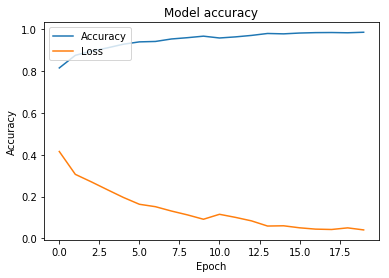

In [30]:
# Visualization corresponding to the training process between accuracy and loss. As you can see, the accuracy or 
# loss parameters are not stablizing. It means that, there is more scope to train this model for more epochs.  
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

In [31]:
# with 50% confidence applied on the notnormaltarget, the model predicts about 75% for correct labels. 
ypred = list(map(lambda x: 1 if x > 0.5 else 0, model.predict(xdata)[:, 1]))

In [32]:
print(model.evaluate(xdata, encoder.transform(np.asarray(ydata).reshape(-1, 1))))
print('Confusion matrix \n' , pd.crosstab(np.array(ydata), np.array(ypred), rownames=['Actual'], colnames=['Predicted']))

25808/25808 [==============================] - 10s 373us/step
[0.08345077800258742, 0.9793862368257904]
Confusion matrix 
 Predicted      0     1
Actual                
0          16712   245
1            287  8564


C:\Users\Rajesh Rajendran\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


===> Opaque


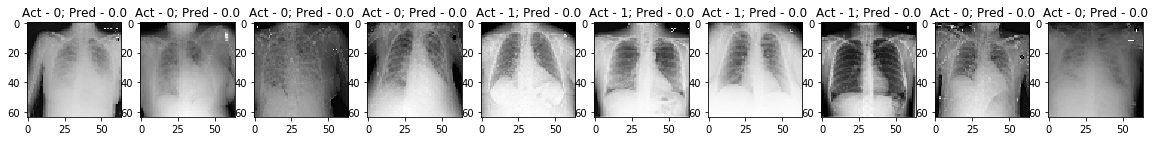

===> Normal


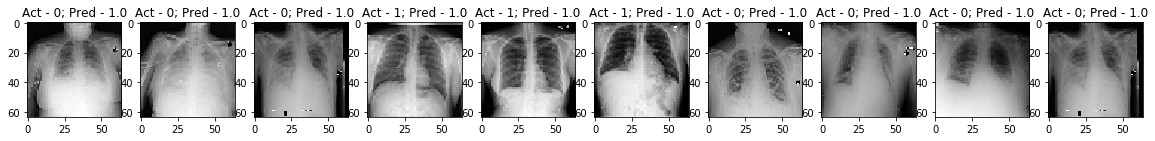

In [34]:
# Visualize the predicted images
dfdata['prediction'] = pd.Series(ypred)
sample = 10

print('===> Opaque')
dftemp = dfdata[dfdata.prediction == 0].sample(sample)
fig, axes = plt.subplots(1, len(dftemp), figsize = (20, 6))
for i in range(len(dftemp)):
    pixels = dftemp.iloc[i].resizedpixels.reshape((64,64))
    axes[i].imshow(pixels, cmap='gray')
    axes[i].set_title('Act - ' + str(dftemp.iloc[i].normaltarget) + '; Pred - ' +  str(dftemp.iloc[i].prediction) )
plt.show()

print('===> Normal')
dftemp = dfdata[dfdata.prediction == 1].sample(sample)
fig, axes = plt.subplots(1, len(dftemp), figsize = (20, 6))
for i in range(len(dftemp)):
    pixels = dftemp.iloc[i].resizedpixels.reshape((64,64))
    axes[i].imshow(pixels, cmap='gray')
    axes[i].set_title('Act - ' + str(dftemp.iloc[i].normaltarget) + '; Pred - ' +  str(dftemp.iloc[i].prediction) )
plt.show()

In [35]:
# Save the model 
model.save('models/Normal.h5')

# Sample code to retrieve model
#from keras.models import load_model
#mdl = load_model('models/Notnormal.h5')
#mdl.evaluate(xtest, ytest)

#### Whats next? 

Now we know what pictures are to be excluded. What it means is the radio pictures that are consider either 'Normal' or 'Opacity Found' will be considered for second model. Patients with not normal images can be adviced to go for redoing the chest xray.

#### Internals of Model 2

Model 2 will be classifying the images with opacity 

In [31]:
# The helper function will split the 2d image to specified amount of images equally in equal direction. Each squred portion 
# will be evaluated if it has any opacity. 
def split_array(data, splitby=2):

    stepi = data.shape[0] / splitby
    stepj = data.shape[1] / splitby

    data_array = []
    for i in range(splitby):
        for j in range(splitby):
            data_array.append(data[np.int(i*stepi):np.int((i+1)*stepi), np.int(j*stepj):np.int((j+1)*stepj)])
            
    return data_array

# Test the above function to split an image of (1024, 1024) size to multiple (32, 32) equal images. 
data = df.pixels.iloc[0].reshape((1024,1024))
data = split_array(data, splitby=32)
print(len(data), data[0].shape)

1024 (32, 32)


In [32]:
# preprocess data... delete few columns from the dataframe and age will be binarized to differnent column. 
del(df['notnormaltarget'])
del(df['resizedpixels'])

try:
    df.sex = df.sex.apply(lambda x: x.strip().decode('utf-8'))
except:
    print('Already adjusted age')
    
try:
    df.viewposition = df.viewposition.apply(lambda x: x.strip().decode('utf-8'))
except:
    print('Already adjusted view position')

df [['sexF', 'sexM']] = pd.get_dummies(df.sex)
df [['vpAP', 'vpPA']] = pd.get_dummies(df.viewposition)

# max value is 100
def agebinarize(x):
    
    retval = list(str(bin(x)).replace('0b',''))
    while len(retval) < 7:
        retval = ['0'] + retval
        
    return retval

df.adjustedage = df.age.apply(lambda x: x if x <= 100 else 100)
df[['age7', 'age6', 'age5', 'age4', 'age3', 'age2', 'age1']] = pd.DataFrame(list(df.adjustedage.apply(agebinarize)), 
                                                                            columns = ['age7', 'age6', 'age5', 'age4', 'age3', 'age2', 'age1'])

df.head()

C:\Users\Rajesh Rajendran\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


,patientId,x,y,width,height,age,sex,viewposition,Target,class,...,sexM,vpAP,vpPA,age7,age6,age5,age4,age3,age2,age1
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,51,F,PA,0,No Lung Opacity / Not Normal,...,0,0,1,0,1,1,0,0,1,1
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,48,F,PA,0,No Lung Opacity / Not Normal,...,0,0,1,0,1,1,0,0,0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,19,M,AP,0,No Lung Opacity / Not Normal,...,1,1,0,0,0,1,0,0,1,1
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,28,M,PA,0,Normal,...,1,0,1,0,0,1,1,1,0,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,32,F,AP,1,Lung Opacity,...,0,1,0,0,1,0,0,0,0,0


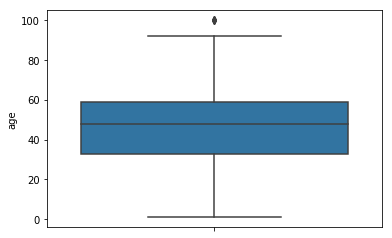

In [38]:
sb.boxplot(y =df.adjustedage) 
plt.show()

In [39]:
# View clean data after features are categorized. 
dfdatafull = df[df['class'].apply(lambda x: False if x == 'No Lung Opacity / Not Normal' else True)][['patientId', 'x', 'y', 
                                                                                                      'width', 'height', 'Target', 
                                                                                                      'pixels', 'age7', 'age6', 
                                                                                                      'age5', 'age4', 'age3', 
                                                                                                      'age2', 'age1', 'sexF', 
                                                                                                      'sexM', 'vpAP', 'vpPA']]
dfdatafull = dfdatafull.reset_index(drop=True)
dfdatafull.head()

,patientId,x,y,width,height,Target,pixels,age7,age6,age5,age4,age3,age2,age1,sexF,sexM,vpAP,vpPA
0,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,"[209, 211, 212, 212, 210, 207, 205, 204, 204, ...",0,0,1,1,1,0,0,0,1,0,1
1,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,"[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, ...",0,1,0,0,0,0,0,1,0,1,0
2,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,"[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, ...",0,1,0,0,0,0,0,1,0,1,0
3,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,"[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, ...",0,1,0,0,0,0,0,1,0,1,0
4,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,"[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, ...",0,1,0,0,0,0,0,1,0,1,0


In [40]:
# Helper function to generate x and y coordinates for bounding boxes. 
def GetMaxValue(x):
    mn = x[0]
    mx = x[1]
    
    retval = np.nan
    
    if (not np.isnan(mn)) and (not np.isnan(mx)):
        retval = mn + mx
        
    return retval

dfdatafull['xmin'] = dfdatafull.x
dfdatafull['ymin'] = dfdatafull.y
dfdatafull['xmax'] = pd.Series(zip(dfdatafull.x, dfdatafull.width)).apply(GetMaxValue)
dfdatafull['ymax'] = pd.Series(zip(dfdatafull.y, dfdatafull.height)).apply(GetMaxValue)
#pd.Series(zip(dfdatafull.x, dfdatafull.width)).apply(GetMaxValue)
del(dfdatafull['x'])
del(dfdatafull['y'])
del(dfdatafull['width'])
del(dfdatafull['height'])
dfdatafull.head()

,patientId,Target,pixels,age7,age6,age5,age4,age3,age2,age1,sexF,sexM,vpAP,vpPA,xmin,ymin,xmax,ymax
0,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,"[209, 211, 212, 212, 210, 207, 205, 204, 204, ...",0,0,1,1,1,0,0,0,1,0,1,NaN,NaN,NaN,NaN
1,00436515-870c-4b36-a041-de91049b9ab4,1,"[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, ...",0,1,0,0,0,0,0,1,0,1,0,264.0,152.0,477.0,531.0
2,00436515-870c-4b36-a041-de91049b9ab4,1,"[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, ...",0,1,0,0,0,0,0,1,0,1,0,264.0,152.0,477.0,531.0
3,00436515-870c-4b36-a041-de91049b9ab4,1,"[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, ...",0,1,0,0,0,0,0,1,0,1,0,562.0,152.0,818.0,605.0
4,00436515-870c-4b36-a041-de91049b9ab4,1,"[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, ...",0,1,0,0,0,0,0,1,0,1,0,562.0,152.0,818.0,605.0


In [41]:
# Helper function to generated masked datalabels. 
def MakeMasks(x):
    pix = x[0]
    xmin, xmax, ymin, ymax = pix = x[1], x[2], x[3], x[4]
    #print(xmin, xmax, ymin, ymax)
    zeros = np.zeros((1024,1024))
    
    if (not np.isnan(xmin)):
        zeros[np.int(xmin):np.int(xmax), np.int(ymin):np.int(ymax)] = 1
    
    return zeros

#i = 1
#arr = MakeMasks(list(zip(dfdatafull.pixels, dfdatafull.xmin, dfdatafull.xmax, dfdatafull.ymin, dfdatafull.ymax))[i])
#arr[np.int(dfdatafull.iloc[i].xmin):np.int(dfdatafull.iloc[i].xmax), 
#    np.int(dfdatafull.iloc[i].ymin):np.int(dfdatafull.iloc[i].ymax)]

In [42]:
# Generate masked data labels. 
masks = pd.Series(zip(dfdatafull.pixels, dfdatafull.xmin, dfdatafull.xmax, dfdatafull.ymin, dfdatafull.ymax)).apply(MakeMasks)

MemoryError: 

In [127]:
# Due to memory constraints, I have difficulty proceeding. Might be good idea to migrate to google
# colabs. 

# Originally, I planned to segregate the total image into multiple parts of smaller images to be fed into neural 
# networks. For example, a single image of size (1024 X 1024) when split by (16 X 16) images both vertically and 
# horizontally (the helper function split_array will help to split it appropriatly) can produce 4096 chunks from 
# each picture. An analysis for each chunk will have 256 features. The chunks can be labeled as opaque or normal 
# depending on the bounding boxes. This requires training process to train for 100M records. This is a lot of data 
# and may not have memory to process such size. 

# Alternatively, I plan to use masked RCNN model to utilize the bounding boxes to mark the pixels 
# where opacity is found. Will plan to include the training and evaluation process in my next 
# checkpoint. But at the end of it, i plan to generate a ML pipeline to determine if the radiographic
# picture is good or not. A good radiographic image will go through the next step to identify the 
# opacity.